# Time Series Forecasting with Autoregressive GPT 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import os
import random
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    #'lags': 90,
    #'forecast': 10,
    'window_size': 100, # also 'context_size'
    'input_features_size': 16,
    'date_input_features_size': 3, # (MONTH, DAY, HOUR)
    'date_features_dim': 64,
    'hidden_features_size': 192-64, # will be concat inside model
    'output_features_size': 16,
    'num_heads': 12,
    'ff_dim': 192*4, # usually 4 times the hidden feature size
    'num_decoder_layers': 6,
    'emb_dropout_prob': 0.1,
    'attn_dropout_prob': 0.1,
    'ff_dropout_prob': 0.1,
    'attn_use_bias': False,
    'ff_use_bias': False,
    'output_features_bias': False,
    'batch_size': 128,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 75,
    'use_amp': True, # USE MIXED PRECISION
}

#hyperparameters['window_size'] =  hyperparameters['lags'] + hyperparameters['forecast']

# Dataset

In [3]:
# Airline Passgeners
#df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')

# Panama Electricity Load Forecasting
df_full = pd.read_csv('data/panama_electricity_load_forecasting/train.csv')

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
# Airline Passgeners
#df_full['Month'] = pd.to_datetime(df_full['Month'])

# Panama Electricity Load Forecasting
df_full['datetime'] = pd.to_datetime(df_full['datetime'], dayfirst=True)

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
# # Airline Passgeners
#df_full.set_index('Month', inplace=True)

# Panama Electricity Load Forecasting
df_full.set_index('datetime', inplace=True)

df_full.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


<Axes: xlabel='datetime'>

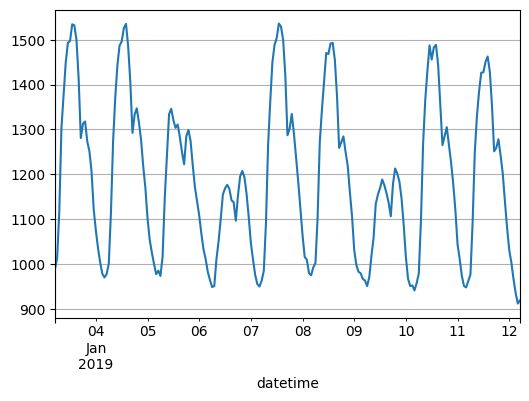

In [6]:
# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='datetime'>

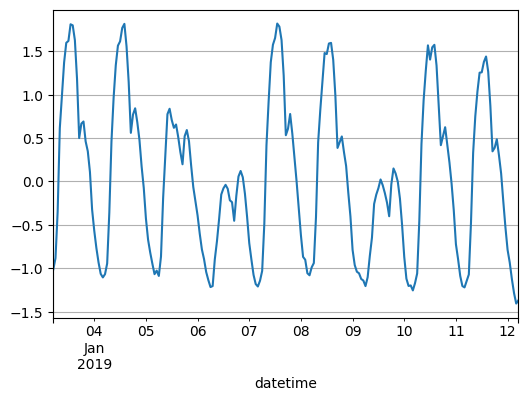

In [7]:
scaler = StandardScaler()

# Airline Passgeners
#df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))

# Panama Electricity Load Forecasting
df_full['nat_demand'] = scaler.fit_transform(df_full['nat_demand'].values.reshape(-1, 1))

# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

In [8]:
tstamp = df_full.index[-1]
tstamp

Timestamp('2019-12-31 23:00:00')

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [9]:
df_full.shape

(43775, 16)

# Model

In [10]:
from models.transformer import GPTTimeSeries

## Transformer Model
### Initialized Model with Hyperparameters

In [11]:
model = GPTTimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    date_input_features_size=hyperparameters['date_input_features_size'],
    date_features_dim=hyperparameters['date_features_dim'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    #forecast_size=hyperparameters['forecast'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)

### Number of parameters

In [12]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [13]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
2,664,704


In [14]:
dummy_data = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['input_features_size'])
dummy_date = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['date_input_features_size'])

o = model(dummy_data, dummy_date)
o.shape

torch.Size([128, 100, 16])

# Dataset

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size
        
    def __len__(self):
        number_of_samples = self.df.shape[0]
        # make sure that last window fits
        return number_of_samples - self.window_size

    def __getitem__(self, start_idx):

        # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
        df_window = self.df.iloc[start_idx:start_idx+self.window_size]

        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp_lags = df_window[:-1].index
            
        # divide window into lags and forecast (shifted by 1)
        # first window_size-1 steps
        lags = sample_window[:-1, :]
        # last window_size-1 steps
        forecast = sample_window[1:, :]

        # convert to tensor
        lags = torch.tensor(lags, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)
        
        # (lags, date_input_features_size)
        date = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32).permute(1, 0)
        
        return lags, forecast, date

In [16]:
dataset_full = TimeSeriesDataset(
    df_full,
    hyperparameters['window_size'],
)

In [17]:
_lags, _forecast, _date = dataset_full[0]
_lags.shape, _forecast.shape, _date.shape

(torch.Size([99, 16]), torch.Size([99, 16]), torch.Size([99, 3]))

### Train/Test Split

In [18]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(34940, 8735)

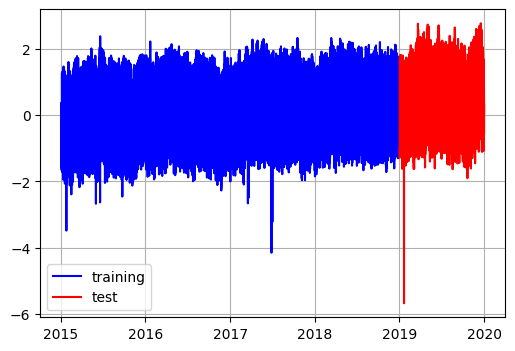

In [19]:
df_train = df_full.iloc[:train_size, :]
df_test = df_full.iloc[-test_size:, :]

# Airline Passgeners
#plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
#plt.plot(df_test.index, df_test['Passengers'], c='red', label='test')

# Panama Electricity Load Forecasting
plt.plot(df_train.index, df_train['nat_demand'], c='blue', label='training')
plt.plot(df_test.index, df_test['nat_demand'], c='red', label='test')

plt.legend()

In [20]:
dataset_train = TimeSeriesDataset(
    df_train,
    hyperparameters['window_size'],
)

dataset_test = TimeSeriesDataset(
    df_test,
    hyperparameters['window_size'],
)

# Dataloader

In [21]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 342
Number of batches (train): 273
Number of batches (test): 68


In [22]:
_lags_batch, _forecast_batch, _date_batch = next(iter(dataloader_full))
# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)
_lags_batch.shape, _forecast_batch.shape, _date_batch.shape

(torch.Size([128, 99, 16]),
 torch.Size([128, 99, 16]),
 torch.Size([128, 99, 3]))

In [23]:
len(dataloader_full)

342

# Training

### Training Functions
* with AMP support

In [24]:
def train_iter(model, dataloader, optimizer, criterion, scaler, use_amp, device):
    model.train()

    avg_loss = []
    
    for (lags, forecast, date) in dataloader:

        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
        
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            # AMP forward pass
            forecast_pred = model(lags, date)
            loss = criterion(forecast_pred, forecast)
        
        scaler.scale(loss).backward()  #loss.backward()
        scaler.step(optimizer)         #optimizer.step()
        scaler.update()
        optimizer.zero_grad()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, dataloader, criterion, use_amp, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    for (lags, forecast, date) in dataloader:
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
                
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            # AMP forward pass
            forecast_pred = model(lags, date)
            loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [25]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.1, 
    patience=3,
    min_lr=1e-6,
)

scaler = torch.cuda.amp.GradScaler(enabled=hyperparameters['use_amp'])

mse_loss = nn.MSELoss()

In [26]:
model.to(device)

for epoch in range(1, hyperparameters['num_epochs']+1):
        
    avg_train_loss = train_iter(
        model=model, 
        dataloader=dataloader_train, 
        optimizer=optimizer, 
        criterion=mse_loss, 
        scaler=scaler, 
        use_amp=hyperparameters['use_amp'], 
        device=device
    )
    
    avg_test_loss, _ = eval_iter(
        model=model, 
        dataloader=dataloader_test, 
        criterion=mse_loss, 
        use_amp=hyperparameters['use_amp'],
        device=device
    )

    # auto decrease LR when not improving
    scheduler.step(avg_test_loss)
    
    """
    # MANUAL LR SCHEDULING
    if epoch == 30:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1

    if epoch == 60:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
    """
    
    print(f'Epoch: {epoch:<3}, Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}, LR: {scheduler.get_last_lr()}')

Epoch: 1  , Training loss: 29.8889, Testing Loss: 6.9068, LR: [0.001]
Epoch: 2  , Training loss: 6.8774, Testing Loss: 7.1886, LR: [0.001]
Epoch: 3  , Training loss: 6.9934, Testing Loss: 7.1629, LR: [0.001]
Epoch: 4  , Training loss: 6.9973, Testing Loss: 7.0971, LR: [0.001]
Epoch: 5  , Training loss: 6.9564, Testing Loss: 7.1451, LR: [0.0001]
Epoch: 6  , Training loss: 6.4346, Testing Loss: 6.6113, LR: [0.0001]
Epoch: 7  , Training loss: 6.2717, Testing Loss: 6.5399, LR: [0.0001]
Epoch: 8  , Training loss: 6.2513, Testing Loss: 6.5243, LR: [0.0001]
Epoch: 9  , Training loss: 6.2478, Testing Loss: 6.5189, LR: [0.0001]
Epoch: 10 , Training loss: 6.2475, Testing Loss: 6.5173, LR: [0.0001]
Epoch: 11 , Training loss: 6.2476, Testing Loss: 6.5182, LR: [0.0001]
Epoch: 12 , Training loss: 6.2471, Testing Loss: 6.5172, LR: [0.0001]
Epoch: 13 , Training loss: 6.2447, Testing Loss: 6.5132, LR: [0.0001]
Epoch: 14 , Training loss: 6.2364, Testing Loss: 6.5026, LR: [0.0001]
Epoch: 15 , Training lo

# Testing
* NOTE: we prefer to use single windows step during prediction

In [27]:
@torch.no_grad()
def eval_iter_single_step(model, dataloader, criterion, use_amp, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    # single step
    for start_idx in tqdm(range(0, len(df_test)-hyperparameters['window_size'])):

        # single step window sliding
        df_window = df_test.iloc[start_idx:start_idx+hyperparameters['window_size'], :]

        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp_lags = df_window[:-1].index

        # covnert to tensor
        lags = torch.tensor(sample_window[:-1], dtype=torch.float32, device=device)
        forecast = torch.tensor(sample_window[1:], dtype=torch.float32, device=device)
        # (lags, date_input_features_size)
        date = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32, device=device).permute(1, 0)
        
        # artificially add batch dimension
        # (we are not using the dataloader here!)
        lags = lags.unsqueeze(0)
        forecast = forecast.unsqueeze(0)
        date = date.unsqueeze(0)

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            forecast_pred = model(lags, date)
            loss = criterion(forecast_pred, forecast)
            
        avg_loss.append(loss.item())
        # (batch, forecast, output_features_size)-> (1, window_size-1, output_features_size)
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        predictions.append(forecast_pred[0][-1].cpu().numpy())

    return sum(avg_loss) / len(avg_loss), predictions

In [28]:
_, pred_sliding = eval_iter_single_step(
    model=model, 
    dataloader=dataloader_test, 
    criterion=mse_loss, 
    use_amp=hyperparameters['use_amp'],
    device=device
)

len(pred_sliding)

100%|██████████████████████████████████████████████████████████████████████████| 8635/8635 [00:43<00:00, 200.62it/s]


8635

In [29]:
df_full.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [30]:
sliding_results_dict = {}

pred_sliding_array = np.array(pred_sliding)

for feature_id, feature_key in enumerate(df_full.columns):
    sliding_results_dict[feature_key] = pred_sliding_array[:, feature_id]
        
df_sliding = pd.DataFrame(data=sliding_results_dict, index=df_test.index[:-hyperparameters['window_size']])

df_sliding.head(10)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-01-02 01:00:00,-0.845215,25.562500,0.018005,0.061035,21.390625,23.484375,0.017395,0.069763,9.757812,22.265625,0.016068,0.123596,5.468750,0.023254,0.031982,0.331055
2019-01-02 02:00:00,-0.885254,25.468750,0.017960,0.058960,20.812500,23.359375,0.017349,0.068115,9.281250,22.171875,0.016052,0.122620,5.281250,0.029572,0.027863,0.332275
2019-01-02 03:00:00,-0.930664,25.375000,0.017929,0.056244,19.750000,23.218750,0.017273,0.065613,8.531250,22.093750,0.016052,0.121582,4.960938,0.038788,0.024841,0.338867
2019-01-02 04:00:00,-0.923828,25.359375,0.017899,0.053741,19.156250,23.234375,0.017242,0.063171,8.031250,22.093750,0.016052,0.120361,4.718750,0.045349,0.025253,0.340576
2019-01-02 05:00:00,-0.434082,26.234375,0.018356,0.059845,22.031250,24.671875,0.017883,0.068604,10.289062,23.062500,0.016479,0.118591,5.187500,-0.120850,0.019745,0.343994
2019-01-02 06:00:00,0.050201,26.968750,0.018478,0.059540,25.843750,26.281250,0.018234,0.063782,12.132812,24.125000,0.016510,0.111023,5.179688,-0.080566,0.034973,0.363770
2019-01-02 07:00:00,0.275635,27.484375,0.018509,0.066101,26.921875,27.140625,0.018173,0.068848,13.570312,24.781250,0.016479,0.115356,5.484375,-0.082275,0.029663,0.369629
2019-01-02 08:00:00,0.407959,27.828125,0.018585,0.066528,26.656250,27.687500,0.018234,0.070190,13.679688,25.234375,0.016556,0.115784,5.308594,-0.101807,0.023483,0.382568
2019-01-02 09:00:00,0.535156,28.140625,0.018692,0.065552,26.000000,28.218750,0.018280,0.070496,13.500000,25.687500,0.016647,0.114624,4.992188,-0.125488,0.018570,0.398438


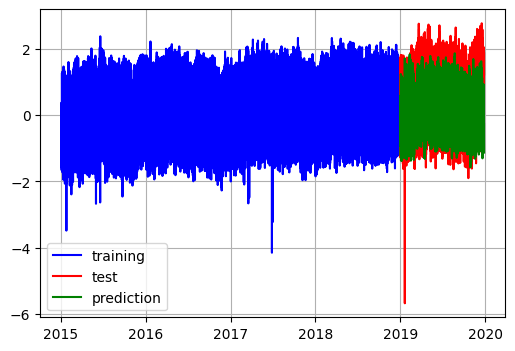

In [31]:
selected_feature = 'nat_demand'

df_train_plot = df_train[:-hyperparameters['window_size']].copy()
df_test_plot = df_test[:-hyperparameters['window_size']].copy()

plt.plot(df_train_plot.index, df_train_plot[selected_feature], c='blue', label='training')
plt.plot(df_test_plot.index, df_test_plot[selected_feature], c='red', label='test')
plt.plot(df_sliding.index, df_sliding[selected_feature] , c='green', label='prediction')
plt.legend()

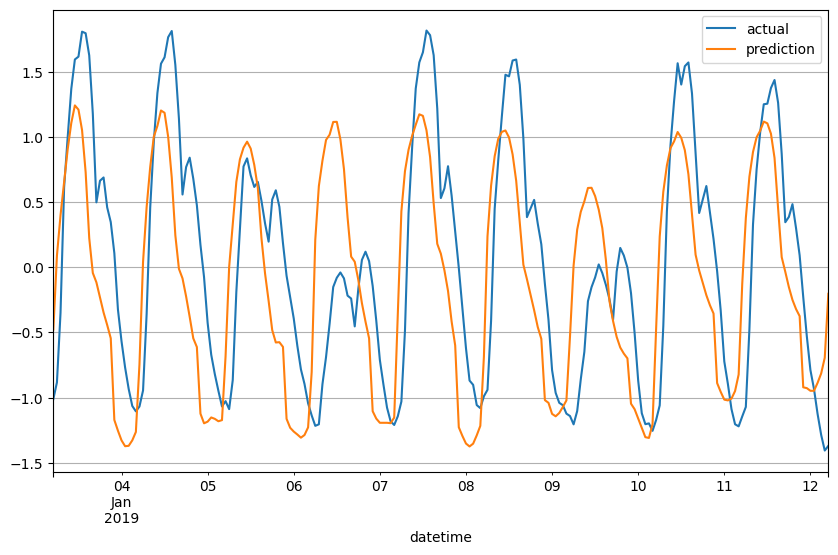

In [32]:
plt.figure(figsize=(10, 6))
df_test.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='actual')
df_sliding.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='prediction')
plt.legend()

# Save Model

In [33]:
os.makedirs('./saved_models', exist_ok=True)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': hyperparameters,
}

if hyperparameters['use_amp']:
    checkpoint['scaler_state_dict'] = scaler.state_dict()

torch.save(
    checkpoint,
    './saved_models/GPTTimeSeries_Autoregressive.pt'
)

# Generative Forecast

In [34]:
@torch.no_grad()
def generative_forecast(model, data, num_steps, lag_window_size, use_amp, device):
    model.eval()
    
    predictions = []
    time_indexes = []
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    timestamps = df_full.index
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        return torch.tensor([_timestamp.month, _timestamp.day, _timestamp.hour], dtype=torch.float32, device=_device).permute(1, 0)
    
    # single step
    for idx in range(num_steps):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)

        # date
        date = generate_date_tensor(timestamps, lag_window_size, device).unsqueeze(0)

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            forecast_pred = model(lags, date)
        
        # (batch, forecast, output_features_size)-> (1, window_size-1, output_features_size)
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        predictions.append(forecast_pred[0][-1].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)

        # append last forecast to the end
        lags = torch.cat((lags, forecast_pred.detach()), dim=1)

        # next timestamp
        timestamps = timestamps + delta_time

    return predictions, time_indexes

In [35]:
pred_generative, time_indexes_generative = generative_forecast(model, df_full.values, 15, hyperparameters['window_size'], hyperparameters['use_amp'], device)

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_full.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

<Axes: >

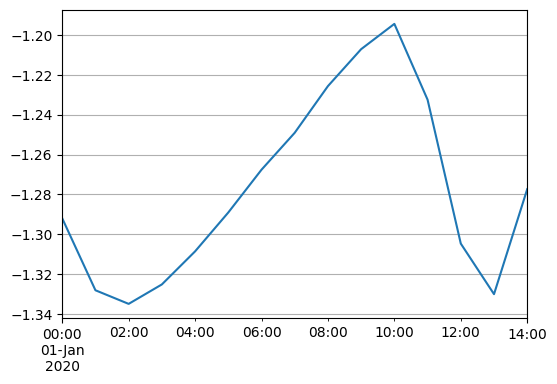

In [36]:
df_generative[selected_feature].plot()